# Klasifikasi Tumor Otak pada Gambar MRI
### Fahmi Jabbar (1801389)
---
**Informasi Dataset :**
![Dataset](https://image.prntscr.com/image/3D0qQ1ZySkuarGolLUndOg.png)

Sumber : https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri


## Import Library

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, random, time
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install split-folders tqdm
import splitfolders

## Cek Hardware

### Ketersediaan Hardware Penunjang

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Detail GPU

In [ ]:
!nvidia-smi

Sun Jan  3 12:57:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Persiapan Dataset

### Download dataset dengan kaggle API

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "fahmijabbar"
os.environ['KAGGLE_KEY'] = "38196642493f1560965029fefcee361d"

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 2.58MB/s]


### Unzip Dataset

In [ ]:
!unzip -q /content/brain-tumor-classification-mri.zip -d /content/dataset/

### Rename dan copy dataset

In [ ]:
path = '/content/dataset'
folder = os.listdir(path)
for subfolder in folder:
  subpath = path+"/"+subfolder 
  files = os.listdir(subpath)
  for subs in files:
    subs = path+"/"+subfolder+"/"+subs
    files = os.listdir(subs)
    for index, file in enumerate(files):
      os.rename(os.path.join(subs, file), os.path.join(subs, ''.join([subfolder,'-',str(index), '.jpg'])))

In [ ]:
!mv /content/dataset/Training/glioma_tumor/ /content/dataset/glioma_tumor
!mv /content/dataset/Training/meningioma_tumor/ /content/dataset/meningioma_tumor
!mv /content/dataset/Training/no_tumor/ /content/dataset/no_tumor
!mv /content/dataset/Training/pituitary_tumor/ /content/dataset/pituitary_tumor
!mv /content/dataset/Testing/glioma_tumor/* /content/dataset/glioma_tumor/
!mv /content/dataset/Testing/meningioma_tumor/* /content/dataset/meningioma_tumor/
!mv /content/dataset/Testing/no_tumor/* /content/dataset/no_tumor/
!mv /content/dataset/Testing/pituitary_tumor/* /content/dataset/pituitary_tumor/
!rm -rf /content/dataset/Training/
!rm -rf /content/dataset/Testing/

## Eksplorasi dan Analisis Dataset

In [ ]:
base_dir = '/content/dataset/'
labels = os.listdir(base_dir)
countedlabel = []

In [ ]:
# Count total images each classes
file_count = []
for label in labels:
  dir = base_dir + label
  path, dirs, files = next(os.walk(dir))
  file_count.append(len(files))
print("Consist of " + str(len(file_count)) + " Classes")

# Count total images
total = 0
for num in file_count:
  total += num
print("And " + str(total) + " Total Images")

# Append total image in classes
x = 0
while x < len(labels):
  countedlabel.append(labels[x] + " (" + str(file_count[x]) + ")")
  x += 1

Consist of 4 Classes
And 3264 Total Images


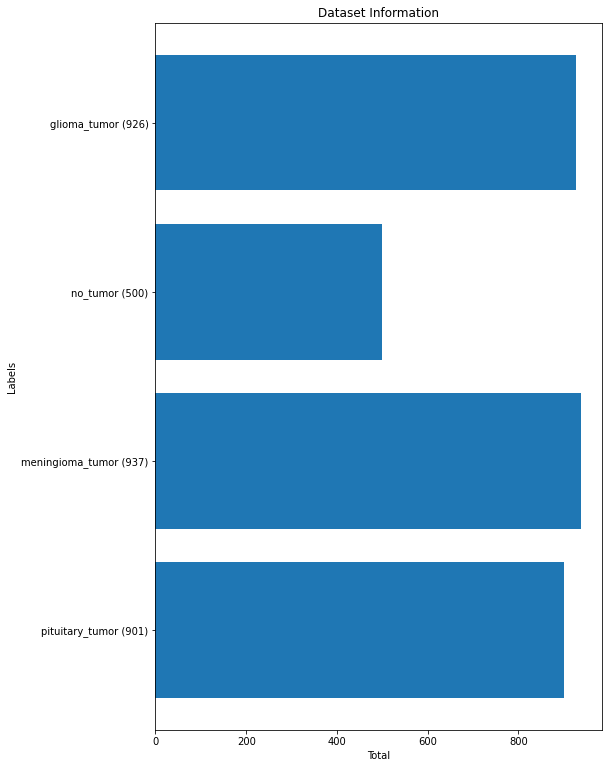

In [ ]:
plt.figure(figsize=(8,13))
plt.barh(np.arange(len(labels)), file_count)
plt.yticks(np.arange(len(labels)), countedlabel)
plt.title('Dataset Information')
plt.xlabel('Total')
plt.ylabel('Labels')
plt.show()

## Pembagian dataset
![Dataset Split](https://developers.google.com/machine-learning/crash-course/images/PartitionThreeSets.svg)

Referensi : https://developers.google.com/machine-learning/crash-course/validation/another-partition

In [ ]:
splitfolders.ratio(base_dir, output="/content/splitted/", seed=1337, ratio=(.7, .2, .1))

Copying files: 3264 files [00:00, 7728.17 files/s]


## Augmentasi Dataset

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, #Normalization
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #Normalization
)

## Feed gambar dataset kedalam generator

In [ ]:
img_shape = (150, 150, 3)
train_generator = train_datagen.flow_from_directory(
    directory="/content/splitted/train",
    target_size= img_shape[:2],
    class_mode='categorical',
    color_mode='rgb',
    batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
    directory="/content/splitted/val",
    target_size= img_shape[:2],
    class_mode='categorical',
    color_mode='rgb',
    batch_size=8)

Found 2283 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


### Helper Function :

In [ ]:
transparent = (255,255,255)
yellow = (245, 180, 0)
green = (0, 170, 0)
red = (220, 0, 0)

def print_in_color(txt_msg,fore_tupple,back_tupple):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    if(rb == 255 and gb == 255 and bb == 255):
      msg='{0}' + txt_msg
      mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2'+ 'm' 
      print(msg .format(mat))
      print('\33[0m')
    else:
      msg='{0}' + txt_msg
      mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
      print(msg .format(mat))
      print('\33[0m')

## Arsitektur Model

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same', input_shape=(150, 150, 3)),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.25),
          tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
          tf.keras.layers.Dropout(0.25),
          tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(128, (2,2), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(256, (2,2), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1024, activation='relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       1

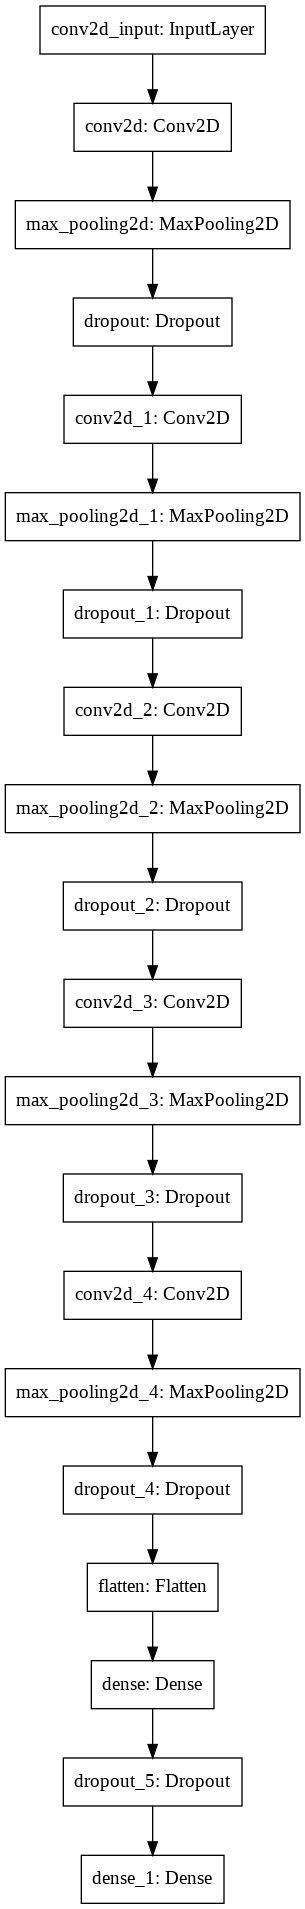

In [ ]:
tf.keras.utils.plot_model(model)

### Kompilasi model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

### Penerapan teknik callback

In [ ]:
class completeCallback(tf.keras.callbacks.Callback):
  best_weights=model.get_weights()
  def __init__(self, patience=2, threshold=.85, factor=.75):
    super(LRA, self).__init__()
    self.patience=patience
    self.threshold=threshold
    self.factor=factor
    self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
    self.highest_tracc=0.0 
    self.lowest_vloss=np.inf
    self.count=0
    msg='Training Model with Self Adjusting Learning Rate\n==============================================='
    print_in_color (msg, (0, 0, 230), (255,255,255))
      
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') >= 0.92):
      msg = "\n\n[i] Reached Accuracy 92% & Val Accuracy 92%, Training is stoped\n"
      print_in_color(msg, (0, 0, 230), transparent)
      self.model.stop_training = True
    else:
      lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
      v_loss=logs.get('val_loss')
      acc=logs.get('accuracy')
      if acc < self.threshold:
        if acc>self.highest_tracc: 
          msg= f'\n[i] training accuracy improved from  {self.highest_tracc:.4f} to {acc:.4f} learning rate held at {lr:.6f}'
          print_in_color(msg, green, transparent)
          self.highest_tracc=acc
          LRA.best_weights=model.get_weights()
          count=0
          if v_loss<self.lowest_vloss:
            self.lowest_vloss=v_loss                    
        else:  
          if self.count>=self.patience-1:
            self.lr= lr * self.factor
            tf.keras.backend.set_value(model.optimizer.lr, self.lr)
            self.count=0
            if v_loss<self.lowest_vloss:
              self.lowest_vloss=v_loss
            msg=f'\n[i] for epoch {epoch+1} training accuracy did not improve for {self.patience} consecutive epochs, learning rate adjusted to {lr:.6f}'
            print_in_color(msg, red, transparent)
          else:
            self.count=self.count+1
            msg=f'\n[i] try number {self.count}, for  epoch {epoch+1} training accuracy did not improve'
            print_in_color(msg, yellow, transparent)
      else:
        if v_loss< self.lowest_vloss:
          msg=f'\n[i] validation loss improved from {self.lowest_vloss:.4f} to {v_loss:.4}, saving best weights'
          print_in_color(msg, green, transparent)
          self.lowest_vloss=v_loss                
          LRA.best_weights=model.get_weights()
          self.count=0      
        else:
          if self.count>=self.patience-1:
            self.lr=self.lr * self.factor
            msg=f'\n[i] for epoch {epoch+1} validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:9.6f}'
            self.count=0
            print_in_color(msg, red, transparent)
            tf.keras.backend.set_value(model.optimizer.lr, self.lr)
          else: 
            self.count =self.count +1 
            msg=f'\n[i] try number {self.count}, for epoch {epoch+1} validation loss did not improve'
            print_in_color(msg, yellow, transparent)

## Training Model

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_generator, 
                      epochs = 50, 
                      validation_data = validation_generator, 
                      verbose = 1,
                      callbacks=[completeCallback()])

Training Model with Self Adjusting Learning Rate

Epoch 1/50
36/36 [==============================] - 13s 339ms/step - loss: 1.4129 - accuracy: 0.3047 - val_loss: 1.2857 - val_accuracy: 0.4617

[i] training accuracy improved from  0.0000 to 0.3530 learning rate held at 0.001000

Epoch 2/50
36/36 [==============================] - 12s 326ms/step - loss: 1.2188 - accuracy: 0.4582 - val_loss: 1.2433 - val_accuracy: 0.4831

[i] training accuracy improved from  0.3530 to 0.4788 learning rate held at 0.001000

Epoch 3/50
36/36 [==============================] - 12s 329ms/step - loss: 1.0522 - accuracy: 0.5488 - val_loss: 1.1619 - val_accuracy: 0.4601

[i] training accuracy improved from  0.4788 to 0.5629 learning rate held at 0.001000

Epoch 4/50
36/36 [==============================] - 12s 330ms/step - loss: 0.9529 - accuracy: 0.5931 - val_loss: 0.8952 - val_accuracy: 0.5844

[i] training accuracy improved from  0.5629 to 0.6093 learning rate held at 0.001000

Epoch 5/50
36/36 [============

## Hasil Training Model

In [ ]:
# Bila model yang di training belum cukup bagus
# gunakan model yang sebelumnya pernah dibuat
model = tf.keras.models.load_model('/content/model0201.h5')

### Evaluasi Model

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
  directory='/content/splitted/test',
  target_size=(150, 150),
  shuffle=False,
  batch_size=2,
  class_mode='categorical')

Found 329 images belonging to 4 classes.


In [ ]:
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

165/165 [==============================] - 9s 11ms/step - loss: 0.2882 - accuracy: 0.9179

accuracy: 91.79%
loss: 28.82%


### Grafik akurasi dan Loss

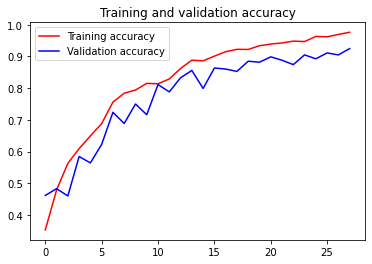

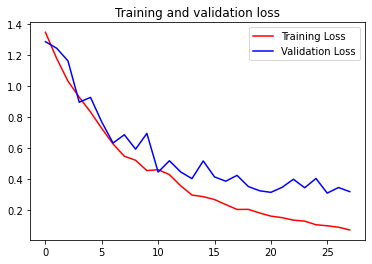

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confussion Matrix

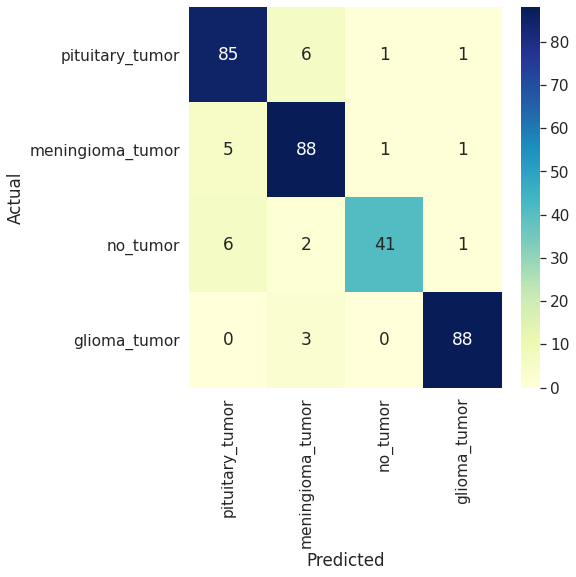

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), columns=labels, index= labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 17})
plt.show()

### Prediksi Model Secara acak dan Tampilan heatmap menggunakan teknik Guided GradCam

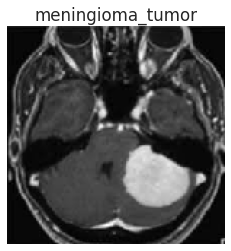

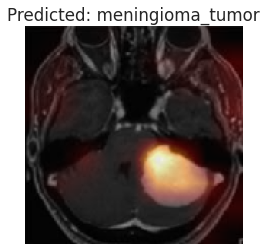

In [ ]:
#Memilih gambar secara acak
folders = random.choice(os.listdir("/content/splitted/test/"))
files = random.choice(os.listdir("/content/splitted/test/"+folders+"/"))

image = np.array(tf.keras.preprocessing.image.load_img("/content/splitted/test/"+folders+"/"+files, target_size=(150, 150, 3)))
x = tf.keras.preprocessing.image.img_to_array(image)
x /= 255
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
classes = model.predict(x, batch_size=1)
plt.imshow(image)
plt.title(folders)
plt.axis("off")
plt.show()
last_conv_layer = model.get_layer("conv2d_4")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["max_pooling2d_4","dropout_4","flatten"]:
  x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (150, 150))
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)
plt.imshow(image)
labels = test_generator.class_indices
labels = {value:key for key, value in labels.items()}
plt.title("Predicted: "+str(labels[np.argmax(classes)]))
plt.imshow(guided_gradcam, alpha=0.5,cmap='afmhot')
plt.axis("off")
plt.show()

## Simpan Model

In [ ]:
model.save('/content/model0201.h5')